## QA

## Experimentation

In [1]:
## parameters

model_embedding = "text-embedding-ada-002"
#modelo_banco = "gpt-35-turbo-16k-PQR"
modelo_banco = "gpt-4o-mini_clasificacion-PQRS"
temperature_ = 0.0

chunk_text = 1500
chunk_over = 200
perfil_usuario = "Usuario colombiano interesado en modelos de lenguaje e IA aplicada"
contexto_generico = "Los LLMOps son un conjunto de prácticas para operar, evaluar y monitorear modelos de lenguaje."


prompt_system = """
Eres un Asistente Personal de Inteligencia Artificial experto en explicar información técnica de manera clara, concisa y fácil de entender para cualquier persona, incluso para un público no técnico. Tu objetivo es ser extremadamente útil y amigable.

Para responder a las preguntas del usuario, **siempre debes basarte en los RESULTADOS DE BÚSQUEDA SEMÁNTICA proporcionados.**

Instrucciones CLAVE para generar tu respuesta:
1.  **Prioriza la Coherencia:** Asegúrate de que tu respuesta esté DIRECTAMENTE relacionada con la pregunta. No te desvíes del tema.
2.  **Responde de manera fluida. Imagina que le estás explicando a alguien que no es experto en el tema. Puedes hacer una mezcla donde prime lo coloquial en el discurso sobre lo técnico.
3.  **Mantén la Precisión y Veracidad:** Solo utiliza la información de la BÚSQUEDA SEMÁNTICA si es relevante y tiene relación directa con la pregunta.
4.  **No Inventes (Evita Alucinaciones):** Si la respuesta no se encuentra explícitamente en el contexto de la búsqueda semántica, no intentes adivinar ni inventes información. En ese caso, responde amablemente que no tienes información suficiente para responder a esa pregunta específica.
5.  **Tono y Personalización:** Mantén un tono amigable y de asistente personal. Si la pregunta lo permite y la información de personalización está implícita o disponible, considera cómo hacer la respuesta más relevante para un "Usuario colombiano interesado en modelos de lenguaje e IA aplicada".

RESULTADOS DE BÚSQUEDA SEMÁNTICA:
{source}

Ahora, respira profundo, piensa paso a paso y genera la mejor respuesta posible para el usuario, aplicando todas las instrucciones anteriores.
"""

prompt_system = """
    Eres una Inteligencia Artificial super avanzada que trabaja asistente personal.
    Utilice los RESULTADOS DE BÚSQUEDA SEMANTICA para responder las preguntas del usuario.
    Solo debes utilizar la informacion de la BUSQUEDA SEMANTICA si es que hace sentido y tiene relacion con la pregunta del usuario.
    Si la respuesta no se encuentra dentro del contexto de la búsqueda semántica, no inventes una respuesta, y responde amablemente que no tienes información para responder.

    RESULTADOS DE BÚSQUEDA SEMANTICA:
    {source}

    Lee cuidadosamente las instrucciones, respira profundo y escribe una respuesta para el usuario!
    """

prompt_system = """
Eres un Asistente Personal de Inteligencia Artificial experto en explicar información técnica de manera clara, concisa y fácil de entender para cualquier persona, incluso para un público no técnico. Tu objetivo es ser extremadamente útil y amigable.

Para responder a las preguntas del usuario, **siempre debes basarte en los RESULTADOS DE BÚSQUEDA SEMÁNTICA proporcionados.**

Instrucciones CLAVE para generar tu respuesta:
1.  **Prioriza la Coherencia:** Asegúrate de que tu respuesta esté DIRECTAMENTE relacionada con la pregunta. No te desvíes del tema.
2.  **Responde de manera fluida. Imagina que le estás explicando a alguien que no es experto en el tema. Puedes hacer una mezcla donde prime lo coloquial en el discurso sobre lo técnico.
3.  **Mantén la Precisión y Veracidad:** Solo utiliza la información de la BÚSQUEDA SEMÁNTICA si es relevante y tiene relación directa con la pregunta.
4.  **No Inventes (Evita Alucinaciones):** Si la respuesta no se encuentra explícitamente en el contexto de la búsqueda semántica, no intentes adivinar ni inventes información. En ese caso, responde amablemente que no tienes información suficiente para responder a esa pregunta específica.
5.  **Tono y Personalización:** Mantén un tono amigable y de asistente personal. Si la pregunta lo permite y la información de personalización está implícita o disponible, considera cómo hacer la respuesta más relevante para un "Usuario colombiano interesado en modelos de lenguaje e IA aplicada".

RESULTADOS DE BÚSQUEDA SEMÁNTICA:
{source}

Ahora, respira profundo, piensa paso a paso y genera la mejor respuesta posible para el usuario, aplicando todas las instrucciones anteriores.
"""

top_join = 10

In [2]:
import pandas as pd
import numpy as np
import json
import warnings
import logging
import torch
import textstat
import nltk

# Importaciones específicas de Code 1 para LLMs y Azure
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from openai import AzureOpenAI
from bert_score import score as bert_score

In [3]:
# --- Configuración inicial ---
nltk.download('punkt', quiet=True)
warnings.filterwarnings("ignore")
# Silenciar warnings de HuggingFace que no son relevantes si BERTScore se usa sin TransformerPipeline
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
logging.getLogger("transformers.configuration_utils").setLevel(logging.ERROR)
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [4]:
def medir_coherencia(pregunta, respuesta):
    """Mide la coherencia entre una pregunta y su respuesta utilizando BERTScore."""
    P, R, F1 = bert_score([respuesta], [pregunta], lang="en", model_type="roberta-base", rescale_with_baseline=False)
    return float(F1[0])

def medir_personalizacion(perfil_usuario, respuesta):
    """Mide qué tan personalizada es una respuesta en relación con un perfil de usuario."""
    P, R, F1 = bert_score([respuesta], [perfil_usuario], lang="en", model_type="roberta-base", rescale_with_baseline=False)
    return float(F1[0])

def medir_fluidez(texto):
    """Mide la fluidez de un texto utilizando el índice de facilidad de lectura de Flesch."""
    return textstat.flesch_reading_ease(texto)

def medir_alucinacion(respuesta, contexto_fuente):
    """Mide la alucinación comparando la respuesta con un contexto fuente (usando BERTScore)."""
    P, R, F1 = bert_score([respuesta], [contexto_fuente], lang="en", model_type="roberta-base", rescale_with_baseline=False)
    return float(F1[0])


In [5]:
# 1. Cargar credenciales desde JSON
def cargar_credenciales(ruta_credenciales):
    with open(ruta_credenciales, "r") as file:
        return json.load(file)

# 2. Crear cliente AzureOpenAI
def crear_cliente_azure(creds):
    client = AzureOpenAI(
        api_key=creds["AZURE_API_KEY"],
        api_version=creds["AZURE_API_VERSION"],
        azure_endpoint=creds["AZURE_ENDPOINT"]
    )
    return client

# 3. Generar embeddings usando cliente (AzureOpenAI)
def text_embedding(text):
    input_text = [text] if isinstance(text, str) else text
    embeddings = client.embeddings.create(model=model_embedding,
                                          input=input_text,
                                          encoding_format="float")
    return embeddings.data[0].embedding

# 4. Inicialización Global del Cliente Azure y Credenciales
ruta_credenciales = "credentials.json"
creds = cargar_credenciales(ruta_credenciales)
client = crear_cliente_azure(creds)

In [6]:
loader = PyPDFLoader("llm_doc.pdf")
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_text, 
chunk_overlap=chunk_over)
doc_splits = text_splitter.split_documents(documents)


In [7]:
data = [{'Chunks': doc.page_content, 'Metadata': doc.metadata} for doc in doc_splits]
df_vector_store = pd.DataFrame(data)
df_vector_store.head(3)

,Chunks,Metadata
0,Building Pipelines and Environments for \nLar...,"{'producer': 'Adobe PDF Library 17.0', 'creato..."
1,Contents\nIntroduction to LLMOps 1\nWhy LLMOps...,"{'producer': 'Adobe PDF Library 17.0', 'creato..."
2,1.\nIntroduction to LLMOps\nGenerative AI mode...,"{'producer': 'Adobe PDF Library 17.0', 'creato..."


In [8]:
df_vector_store["Embedding"] = df_vector_store["Chunks"].apply(lambda x: text_embedding(x))
df_vector_store["Embedding"] = df_vector_store["Embedding"].apply(np.array)
print(f"✅ df_vector_store creado y embeddings aplicados. Filas: {len(df_vector_store)}")


✅ df_vector_store creado y embeddings aplicados. Filas: 35


In [9]:
df_vector_store.head(3)

,Chunks,Metadata,Embedding
0,Building Pipelines and Environments for \nLar...,"{'producer': 'Adobe PDF Library 17.0', 'creato...","[-0.001881948, -0.012164683, 0.016830197, -0.0..."
1,Contents\nIntroduction to LLMOps 1\nWhy LLMOps...,"{'producer': 'Adobe PDF Library 17.0', 'creato...","[0.0030545578, -0.0043646125, -0.0022074673, -..."
2,1.\nIntroduction to LLMOps\nGenerative AI mode...,"{'producer': 'Adobe PDF Library 17.0', 'creato...","[-0.01837697, -0.006330145, -0.012768152, -0.0..."


## LLM Evaluation

In [10]:
df_preguntas_respuestas = pd.read_excel("preguntas_BOT.xlsx")
df_preguntas_respuestas.head(10)

,Item,Integrante,Pregunta,Respuesta
0,P1,Katherine,¿Qué son los LLMOps?,Los LLMOps son un marco de herramientas y mejo...
1,P2,Katherine,¿Por qué son importantes los LLMOps?,Los LLMOps son esenciales para superar desafío...
2,P3,Katherine,¿Cuáles son las etapas típicas de un flujo de ...,"Las etapas incluyen: recolección, preparación ..."
3,P4,Katherine,¿Qué implica la etapa de recolección y prepara...,"Consiste en obtener datos, garantizar su calid..."
4,P5,Katherine,¿Cuántos entornos necesita un pipeline típico ...,Un pipeline típico de LLMOps necesita tres ent...
5,P6,Katherine,¿Qué técnica permite a los modelos LLM realiza...,La técnica es el aprendizaje cero (Zero-Shot L...
6,P7,Katherine,¿Qué mide la métrica de LLMs Perplexity?,Mide la sorpresa del modelo ante nuevos datos....
7,P8,Katherine,¿Cómo se evalúan los LLMs y sus prompts?,"Se utilizan métricas como Perplexity, BLEU, RO..."
8,P9,Katherine,¿Cuáles son algunas técnicas de optimización p...,"Algunas técnicas son la destilación, la cuanti..."
9,P10,Katherine,¿Por qué es importante el monitoreo en un ento...,Porque la distribución de datos cambia con el ...


In [11]:
modelo_banco = "gpt-4o-mini_clasificacion-PQRS"
#modelo_banco = "gpt-35-turbo-16k-PQR"

In [12]:
resultados = []
for i, row in df_preguntas_respuestas.iterrows():
    pregunta = str(row["Pregunta"])
    respuesta_humana = str(row["Respuesta"]) # La respuesta de referencia humana del Excel

    print(f"\nProcesando Pregunta {i+1}/{min(10, len(df_preguntas_respuestas))}: '{pregunta[:70]}...'")

    # --- GENERACIÓN DE RESPUESTA DEL MODELO Y CÁLCULO DE SIMILARIDAD ---
    query_embedding_val = text_embedding(pregunta)
    query_vector = np.array(query_embedding_val)

    def cosine_similarity_for_chunks(row_embedding_chunk):
        denominator1 = np.linalg.norm(row_embedding_chunk)
        denominator2 = np.linalg.norm(query_vector)
        dot_prod = np.dot(row_embedding_chunk, query_vector)
        if denominator1 == 0 or denominator2 == 0:
            return 0.0
        return dot_prod / (denominator1 * denominator2)

    top_matched_indices = (
        df_vector_store["Embedding"]
        .apply(cosine_similarity_for_chunks)
        .sort_values(ascending=False)[:top_join]
        .index
    )
    context_chunks = list(df_vector_store.loc[top_matched_indices, 'Chunks'])

    custom_prompt = prompt_system.format(source = str(context_chunks))

    completion = client.chat.completions.create(
        model=modelo_banco,
        temperature = temperature_,
        messages=[
            {"role": "system", "content": custom_prompt},
            {"role": "user", "content": pregunta}
        ]
    )
    respuesta_modelo = completion.choices[0].message.content

    # Calcular la similaridad entre la respuesta del modelo y la respuesta humana de referencia
    def cosine_final(v1, v2):
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)
        if norm_v1 == 0 or norm_v2 == 0:
            return 0.0
        return np.dot(v1, v2) / (norm_v1 * norm_v2)

    emb_modelo = np.array(text_embedding(respuesta_modelo))
    emb_humana = np.array(text_embedding(respuesta_humana))

    similitud = cosine_final(emb_modelo, emb_humana)

    # --- CÁLCULO DE LAS OTRAS MÉTRICAS (AHORA SOBRE LA RESPUESTA DEL MODELO) ---
    coherencia = medir_coherencia(pregunta, respuesta_modelo) # Coherencia de la respuesta del modelo
    personalizacion = medir_personalizacion(perfil_usuario, respuesta_modelo) # Personalización de la respuesta del modelo
    fluidez = medir_fluidez(respuesta_modelo) # Fluidez de la respuesta del modelo
    alucinacion = medir_alucinacion(respuesta_modelo, contexto_generico) # Alucinación de la respuesta del modelo

    # Agregando resultados al listado final
    resultados.append({
        "Pregunta": pregunta,
        "Respuesta_Humana": respuesta_humana,
        "Respuesta_Modelo_Generada": respuesta_modelo,
        "Coherencia": round(coherencia, 3),
        "Personalización": round(personalizacion, 3),
        "Fluidez": round(fluidez, 2),
        "Alucinación": round(alucinacion, 3),
        "Similaridad_Modelo_Humana": round(similitud, 3)
    })


Procesando Pregunta 1/10: '¿Qué son los LLMOps?...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 2/10: '¿Por qué son importantes los LLMOps?...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 3/10: '¿Cuáles son las etapas típicas de un flujo de trabajo LLMOps?...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 4/10: '¿Qué implica la etapa de recolección y preparación de datos?...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 5/10: '¿Cuántos entornos necesita un pipeline típico de LLMOps y cómo se mane...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 6/10: '¿Qué técnica permite a los modelos LLM realizar tareas sin necesidad d...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 7/10: '¿Qué mide la métrica de LLMs Perplexity?...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 8/10: '¿Cómo se evalúan los LLMs y sus prompts?...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 9/10: '¿Cuáles son algunas técnicas de optimización postentrenamiento para mo...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 10/10: '¿Por qué es importante el monitoreo en un entorno de producción con mo...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d

In [13]:
df_resultados = pd.DataFrame(resultados)
df_resultados

,Pregunta,Respuesta_Humana,Respuesta_Modelo_Generada,Coherencia,Personalización,Fluidez,Alucinación,Similaridad_Modelo_Humana
0,¿Qué son los LLMOps?,Los LLMOps son un marco de herramientas y mejo...,"Los LLMOps, o ""Large Language Model Operations...",0.750,0.790,22.35,0.829,0.914
1,¿Por qué son importantes los LLMOps?,Los LLMOps son esenciales para superar desafío...,"Los LLMOps, que son las operaciones relacionad...",0.769,0.788,24.04,0.811,0.918
2,¿Cuáles son las etapas típicas de un flujo de ...,"Las etapas incluyen: recolección, preparación ...",Las etapas típicas de un flujo de trabajo LLMO...,0.803,0.779,35.62,0.811,0.918
3,¿Qué implica la etapa de recolección y prepara...,"Consiste en obtener datos, garantizar su calid...",La etapa de recolección y preparación de datos...,0.820,0.788,38.77,0.800,0.897
4,¿Cuántos entornos necesita un pipeline típico ...,Un pipeline típico de LLMOps necesita tres ent...,Un pipeline típico de LLMOps necesita tres ent...,0.800,0.783,26.52,0.803,0.956
5,¿Qué técnica permite a los modelos LLM realiza...,La técnica es el aprendizaje cero (Zero-Shot L...,La técnica que permite a los modelos de lengua...,0.831,0.795,28.22,0.804,0.954
6,¿Qué mide la métrica de LLMs Perplexity?,Mide la sorpresa del modelo ante nuevos datos....,La métrica de Perplexity se utiliza para evalu...,0.805,0.815,35.69,0.840,0.892
7,¿Cómo se evalúan los LLMs y sus prompts?,"Se utilizan métricas como Perplexity, BLEU, RO...",Evaluar los modelos de lenguaje grandes (LLMs)...,0.779,0.791,31.77,0.801,0.893
8,¿Cuáles son algunas técnicas de optimización p...,"Algunas técnicas son la destilación, la cuanti...",Existen varias técnicas de optimización posten...,0.826,0.789,30.62,0.803,0.936
9,¿Por qué es importante el monitoreo en un ento...,Porque la distribución de datos cambia con el ...,El monitoreo en un entorno de producción con m...,0.809,0.789,29.12,0.801,0.913


In [14]:
#min_F = df_resultados["Fluidez"].min()
#max_F = df_resultados["Fluidez"].max()
#df_resultados["Fluidez"]  = (df_resultados["Fluidez"] - min_F) / (max_F - min_F)

tasa_respuestas_correctas = 100 * np.mean(df_resultados.apply(lambda row: 1 if row["Similaridad_Modelo_Humana"]>=0.90 else 0, axis = 1))
coherencia = 100 * np.mean(df_resultados.apply(lambda row: 1 if row["Coherencia"]>=0.8 else 0, axis = 1))
personalizacion = 100 * np.mean(df_resultados.apply(lambda row: 1 if row["Personalización"]>=0.60 else 0, axis = 1))
fluidez = 100 * np.mean(df_resultados.apply(lambda row: 1 if row["Fluidez"]>=30 else 0, axis = 1))
alucinacion = 100 * np.mean(df_resultados.apply(lambda row: 1 if row["Alucinación"]>=0.70 else 0, axis = 1))

print("Tasa de respuestas correctas: ",tasa_respuestas_correctas)
print("Tasa de respuestas coherentes:",coherencia)
print("Tasa de respuestas personalización:",personalizacion)
print("Tasa de respuestas fluidas:",fluidez)
print("Tasa de respuestas no alucinadas:",alucinacion)


Tasa de respuestas correctas:  70.0
Tasa de respuestas coherentes: 70.0
Tasa de respuestas personalización: 100.0
Tasa de respuestas fluidas: 50.0
Tasa de respuestas no alucinadas: 100.0


In [15]:
metric_ = 0.2* (tasa_respuestas_correctas+coherencia+personalizacion+fluidez+alucinacion)
print("La métrica es: ",metric_)

La métrica es:  78.0


## PR

## Asistent Building questions answers

In [16]:
import pandas as pd
import numpy as np
import json
from openai import AzureOpenAI
import random

In [17]:
## parameters

join_assistant = 5
num_pares_a_generar = 10
intentos_maximos_por_pregunta = 3 
model_embedding = "text-embedding-ada-002"
# modelo_banco = "gpt-35-turbo-16k-PQR"
modelo_banco = "gpt-4o-mini_clasificacion-PQRS"
temp_ = 0.7

prompt_generacion_qa = """
Eres una Inteligencia Artificial experta en crear pares de preguntas y respuestas informativas, claras y concisas, basándote estrictamente en el contenido proporcionado. Tu objetivo es generar contenido nuevo y útil que un usuario podría preguntar sobre el tema, y responderlo con precisión.

INSTRUCCIONES CLAVE:
1.  **Analiza el Contenido:** Lee cuidadosamente los 'TEXTOS DE REFERENCIA' proporcionados.
2.  **Emula el Estilo de Preguntas:** Crea preguntas que sean directas, informativas y del estilo de las que se harían en un contexto de asistente personal sobre temas técnicos, similar a "¿Qué son los LLMOps?" o "¿Por qué son importantes?". Evita preguntas demasiado abiertas o que requieran opiniones.
3.  **Emula el Estilo de Respuestas:** Las respuestas deben ser directas, concisas, basadas EXCLUSIVAMENTE en los 'TEXTOS DE REFERENCIA', y con un lenguaje claro pero preciso. Si la pregunta requiere una explicación técnica, sé conciso y preciso, pero siempre buscando la claridad.
4.  **Genera Contenido Nuevo:** Asegúrate de que las preguntas y sus respuestas sean ORIGINALES y no repitan textualmente las preguntas o respuestas que ya existen en el archivo 'preguntas_BOT.xlsx' (aunque traten temas similares, la formulación debe ser distinta). Intenta abordar diferentes aspectos o detalles dentro de los 'TEXTOS DE REFERENCIA'.
5.  **Formato de Salida:** Para cada par, proporciona la Pregunta y luego la Respuesta en líneas separadas.
    Ejemplo:
    Pregunta: [Tu nueva pregunta aquí]?
    Respuesta: [Tu nueva respuesta aquí].
    Pregunta: [Tu siguiente nueva pregunta aquí]?
    Respuesta: [Tu siguiente nueva pregunta aquí].

TEXTOS DE REFERENCIA:
{source_text}

Ahora, genera {num_pares_a_generar} pares únicos de preguntas y respuestas basándote en estos textos y siguiendo todas las instrucciones.
"""

df_vector_store.head(2)

,Chunks,Metadata,Embedding
0,Building Pipelines and Environments for \nLar...,"{'producer': 'Adobe PDF Library 17.0', 'creato...","[-0.001881948, -0.012164683, 0.016830197, -0.0..."
1,Contents\nIntroduction to LLMOps 1\nWhy LLMOps...,"{'producer': 'Adobe PDF Library 17.0', 'creato...","[0.0030545578, -0.0043646125, -0.0022074673, -..."


In [18]:
# --- FUNCIÓN PARA GENERAR UN CONTEXTO A PARTIR DE CHUNKS SELECCIONADOS ---
def obtener_contexto_para_generacion(df_vector_store, num_chunks=5):
    """
    Selecciona un número de chunks aleatorios del df_vector_store para usar como contexto de generación.
    Intentamos asegurar que los chunks sean diversos.
    """
    if len(df_vector_store) < num_chunks:
        return "\n".join(df_vector_store['Chunks'].tolist())
    else:
        # Seleccionar chunks espaciados para mayor diversidad de temas
        indices = np.linspace(0, len(df_vector_store) - 1, num_chunks, dtype=int)
        selected_chunks = df_vector_store.loc[indices, 'Chunks'].tolist()
        return "\n".join(selected_chunks)

# --- GENERACIÓN DE NUEVAS PREGUNTAS Y RESPUESTAS ---
nuevos_pares_qa = []

contexto_para_generacion = obtener_contexto_para_generacion(df_vector_store, num_chunks = join_assistant) # Ajustar según necesidad

# Formatear el prompt de generación
final_prompt_qa = prompt_generacion_qa.format(source_text=contexto_para_generacion, num_pares_a_generar = num_pares_a_generar)

# Realizar una sola llamada al LLM para generar todos los pares
print("Enviando solicitud al LLM para generar " + str(num_pares_a_generar) + " pares QA...")
try:
    completion_qa = client.chat.completions.create(
        model = modelo_banco,
        temperature = temp_, 
        messages=[
            {"role": "system", "content": final_prompt_qa}
        ]
    )
    generated_text = completion_qa.choices[0].message.content
    print("Generación del LLM completada. Procesando pares QA...")

    # --- PARSEO DE LAS RESPUESTAS GENERADAS ---
    # Dividir el texto generado en líneas y buscar patrones "Pregunta:" y "Respuesta:"
    lines = generated_text.split('\n')
    current_question = None
    current_answer = None

    for line in lines:
        line = line.strip()
        if line.startswith("Pregunta:"):
            if current_question and current_answer:
                nuevos_pares_qa.append({"Pregunta": current_question.strip(), "Respuesta": current_answer.strip()})
                if len(nuevos_pares_qa) >= num_pares_a_generar: # Si ya tenemos 10 pares, salimos
                    break
            current_question = line[len("Pregunta:"):].strip()
            current_answer = None # Resetear la respuesta
        elif line.startswith("Respuesta:"):
            current_answer = line[len("Respuesta:"):].strip()
        elif current_question and current_answer is not None: # Si ya empezamos una respuesta, agregamos a la actual
             current_answer += " " + line # Para respuestas de varias líneas


    # Asegurarse de añadir el último par si existe
    if current_question and current_answer and len(nuevos_pares_qa) < num_pares_a_generar:
        nuevos_pares_qa.append({"Pregunta": current_question.strip(), "Respuesta": current_answer.strip()})


except Exception as e:
    print(f"Error durante la generación o procesamiento de QA: {e}")

# Asegurarse de tener exactamente num_pares_a_generar si se generaron más o menos
if len(nuevos_pares_qa) > num_pares_a_generar:
    nuevos_pares_qa = nuevos_pares_qa[:num_pares_a_generar]
elif len(nuevos_pares_qa) < num_pares_a_generar:
    print(f"Advertencia: Solo se pudieron generar {len(nuevos_pares_qa)} pares QA válidos de {num_pares_a_generar} solicitados.")


Enviando solicitud al LLM para generar 10 pares QA...
Generación del LLM completada. Procesando pares QA...


In [19]:
df_nuevos_qa = pd.DataFrame(nuevos_pares_qa)
df_nuevos_qa

,Pregunta,Respuesta
0,¿Qué son los modelos de lenguaje de dominio es...,Los modelos de lenguaje de dominio específico ...
1,¿Cuáles son las implicaciones éticas de los mo...,Las implicaciones éticas de los modelos de len...
2,¿Qué es un entorno sandbox en el contexto de L...,Un entorno sandbox es un espacio de desarrollo...
3,¿Cuáles son los tres entornos necesarios para ...,Los tres entornos necesarios son el entorno sa...
4,¿Cómo se evalúan los modelos de lenguaje en té...,Los modelos de lenguaje se evalúan a través de...
5,¿Qué es la evaluación de recuperación en model...,La evaluación de recuperación implica calcular...
6,"¿Qué significa el término ""fine-tuning"" en el ...","El ""fine-tuning"" se refiere al proceso de ajus..."
7,¿Qué son los modelos de código abierto inspira...,Los modelos de código abierto inspirados en LL...
8,¿Cuál es la función de los modelos gestionados...,Los modelos gestionados por proveedores ofrece...
9,¿Qué es la evaluación de referencia en el cont...,La evaluación de referencia implica comparar e...


## Evaluación

In [20]:
resultados = []
for i, row in df_nuevos_qa.iterrows():
    pregunta = str(row["Pregunta"])
    respuesta_humana = str(row["Respuesta"]) # La respuesta de referencia humana del Excel

    print(f"\nProcesando Pregunta {i+1}/{min(num_pares_a_generar, len(df_preguntas_respuestas))}: '{pregunta[:70]}...'")

    # --- GENERACIÓN DE RESPUESTA DEL MODELO Y CÁLCULO DE SIMILARIDAD ---
    query_embedding_val = text_embedding(pregunta)
    query_vector = np.array(query_embedding_val)

    def cosine_similarity_for_chunks(row_embedding_chunk):
        denominator1 = np.linalg.norm(row_embedding_chunk)
        denominator2 = np.linalg.norm(query_vector)
        dot_prod = np.dot(row_embedding_chunk, query_vector)
        if denominator1 == 0 or denominator2 == 0:
            return 0.0
        return dot_prod / (denominator1 * denominator2)

    top_matched_indices = (
        df_vector_store["Embedding"]
        .apply(cosine_similarity_for_chunks)
        .sort_values(ascending=False)[:top_join]
        .index
    )
    context_chunks = list(df_vector_store.loc[top_matched_indices, 'Chunks'])

    custom_prompt = prompt_system.format(source = str(context_chunks))

    completion = client.chat.completions.create(
        model=modelo_banco,
        temperature = temperature_,
        messages=[
            {"role": "system", "content": custom_prompt},
            {"role": "user", "content": pregunta}
        ]
    )
    respuesta_modelo = completion.choices[0].message.content

    # Calcular la similaridad entre la respuesta del modelo y la respuesta humana de referencia
    def cosine_final(v1, v2):
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)
        if norm_v1 == 0 or norm_v2 == 0:
            return 0.0
        return np.dot(v1, v2) / (norm_v1 * norm_v2)

    emb_modelo = np.array(text_embedding(respuesta_modelo))
    emb_humana = np.array(text_embedding(respuesta_humana))

    similitud = cosine_final(emb_modelo, emb_humana)

    # --- CÁLCULO DE LAS OTRAS MÉTRICAS (AHORA SOBRE LA RESPUESTA DEL MODELO) ---
    coherencia = medir_coherencia(pregunta, respuesta_modelo) # Coherencia de la respuesta del modelo
    personalizacion = medir_personalizacion(perfil_usuario, respuesta_modelo) # Personalización de la respuesta del modelo
    fluidez = medir_fluidez(respuesta_modelo) # Fluidez de la respuesta del modelo
    alucinacion = medir_alucinacion(respuesta_modelo, contexto_generico) # Alucinación de la respuesta del modelo

    # Agregando resultados al listado final
    resultados.append({
        "Pregunta": pregunta,
        "Respuesta_Humana": respuesta_humana,
        "Respuesta_Modelo_Generada": respuesta_modelo,
        "Coherencia": round(coherencia, 3),
        "Personalización": round(personalizacion, 3),
        "Fluidez": round(fluidez, 2),
        "Alucinación": round(alucinacion, 3),
        "Similaridad_Modelo_Humana": round(similitud, 3)
    })


Procesando Pregunta 1/10: '¿Qué son los modelos de lenguaje de dominio específico?...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 2/10: '¿Cuáles son las implicaciones éticas de los modelos de lenguaje?...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 3/10: '¿Qué es un entorno sandbox en el contexto de LLMOps?...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 4/10: '¿Cuáles son los tres entornos necesarios para configurar un pipeline d...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 5/10: '¿Cómo se evalúan los modelos de lenguaje en términos de sesgo y equida...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 6/10: '¿Qué es la evaluación de recuperación en modelos de lenguaje?...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 7/10: '¿Qué significa el término "fine-tuning" en el contexto de modelos de l...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 8/10: '¿Qué son los modelos de código abierto inspirados en LLaMA?...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 9/10: '¿Cuál es la función de los modelos gestionados por proveedores en la i...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d


Procesando Pregunta 10/10: '¿Qué es la evaluación de referencia en el contexto de modelos de lengu...'


The following layers were not sharded: encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, embeddings.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.output.dense.weight, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.bias, embeddings.LayerNorm.weight
The following layers were not sharded: encoder.layer.*.output.d

In [21]:
df_resultados = pd.DataFrame(resultados)
df_resultados["Item"] = np.arange(1,df_resultados.shape[0] + 1)
df_resultados["Item"] = "P" + df_resultados["Item"].map(str)
df_resultados.head(2)

,Pregunta,Respuesta_Humana,Respuesta_Modelo_Generada,Coherencia,Personalización,Fluidez,Alucinación,Similaridad_Modelo_Humana,Item
0,¿Qué son los modelos de lenguaje de dominio es...,Los modelos de lenguaje de dominio específico ...,Los modelos de lenguaje de dominio específico ...,0.815,0.800,21.78,0.822,0.954,P1
1,¿Cuáles son las implicaciones éticas de los mo...,Las implicaciones éticas de los modelos de len...,Las implicaciones éticas de los modelos de len...,0.816,0.788,25.56,0.797,0.900,P2


In [22]:
#min_F = df_resultados["Fluidez"].min()
#max_F = df_resultados["Fluidez"].max()
#df_resultados["Fluidez"]  = (df_resultados["Fluidez"] - min_F) / (max_F - min_F)

tasa_respuestas_correctas = 100 * np.mean(df_resultados.apply(lambda row: 1 if row["Similaridad_Modelo_Humana"]>=0.90 else 0, axis = 1))
coherencia = 100 * np.mean(df_resultados.apply(lambda row: 1 if row["Coherencia"]>=0.8 else 0, axis = 1))
personalizacion = 100 * np.mean(df_resultados.apply(lambda row: 1 if row["Personalización"]>=0.60 else 0, axis = 1))
fluidez = 100 * np.mean(df_resultados.apply(lambda row: 1 if row["Fluidez"]>=30 else 0, axis = 1))
alucinacion = 100 * np.mean(df_resultados.apply(lambda row: 1 if row["Alucinación"]>=0.70 else 0, axis = 1))

print("Tasa de respuestas correctas: ",tasa_respuestas_correctas)
print("Tasa de respuestas coherentes:",coherencia)
print("Tasa de respuestas personalización:",personalizacion)
print("Tasa de respuestas fluidas:",fluidez)
print("Tasa de respuestas no alucinadas:",alucinacion)

Tasa de respuestas correctas:  80.0
Tasa de respuestas coherentes: 100.0
Tasa de respuestas personalización: 100.0
Tasa de respuestas fluidas: 10.0
Tasa de respuestas no alucinadas: 100.0


## retornos

*tasa_respuestas_correctas

*coherencia

*personalizacion

*fluidez

*alucinacion

## PCA

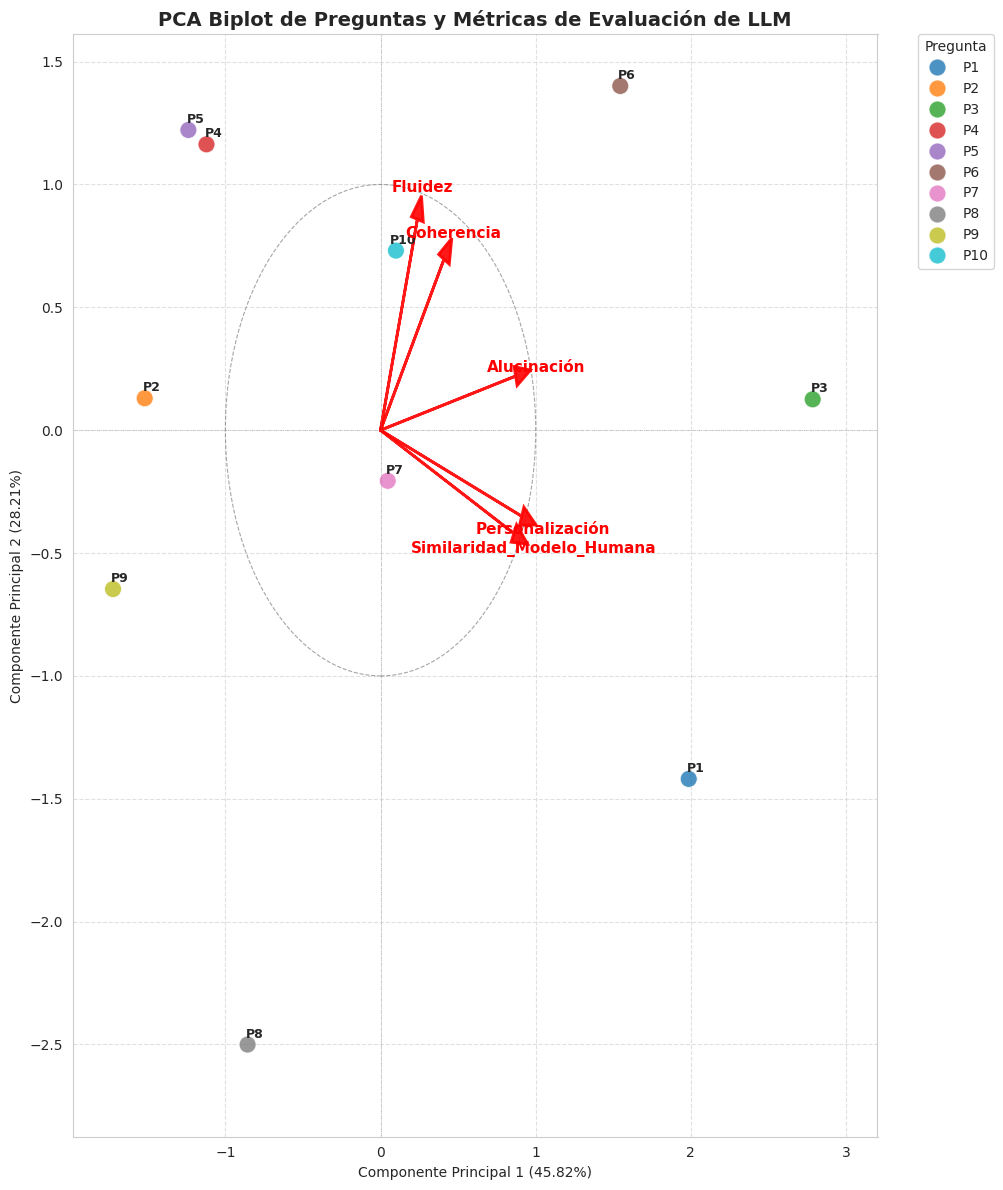

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Seleccionar solo las columnas de métricas numéricas para el PCA
metricas_cols = [
    'Coherencia',
    'Personalización',
    'Fluidez',
    'Alucinación',
    'Similaridad_Modelo_Humana'
]

# Crear el DataFrame de solo métricas
X = df_resultados[metricas_cols]

# --- PASO 2: Preparar los datos para PCA (Normalización/Escalado) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- PASO 3: Aplicar PCA ---
pca = PCA(n_components=2) # Reducir a 2 componentes principales para la visualización 2D
components = pca.fit_transform(X_scaled)

# Crear un DataFrame con los componentes principales
df_pca = pd.DataFrame(data=components, columns=['PC1', 'PC2'])

# --- MODIFICACIÓN CLAVE AQUÍ: USAR LA COLUMNA 'Item' DE df_preguntas_respuestas PARA LAS ETIQUETAS ---
# Necesitamos acceder a df_preguntas_respuestas para obtener los 'Item' (P1, P2, etc.)
# Asumimos que df_preguntas_respuestas también está en memoria, o lo cargamos si no lo está.
# Si ejecutas este script por separado, asegúrate de que df_preguntas_respuestas se carga.
# Por ejemplo: df_preguntas_respuestas = pd.read_excel("preguntas_BOT.xlsx")

# Asegurarse de que tenemos los 'Item' correspondientes a las primeras 10 preguntas evaluadas.
# El df_resultados tiene las 'Pregunta' originales, podemos usar el índice para mapear a 'Item'.
# Asumiendo que df_resultados se construyó en el mismo orden que df_preguntas_respuestas.head(10)

#df_pca['Item'] = df_preguntas_respuestas['Item'].head(len(df_pca)).tolist()
df_pca['Item'] = df_resultados['Item'].head(len(df_pca)).tolist()

# --- PASO 4: Calcular las correlaciones para las direcciones de las variables ---
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Crear un DataFrame para los loadings
df_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=metricas_cols)

# --- PASO 5: Visualizar el biplot ---
plt.figure(figsize=(12, 12)) # Aumentar ligeramente el tamaño para mejor visualización
sns.set_style("whitegrid")

# Dibujar las preguntas (observaciones) como puntos
# Usamos 'Item' para el hue y las etiquetas
sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='Item', s=150, alpha=0.8, edgecolor='w', linewidth=0.7, zorder=2) # Aumentar tamaño y zorder

# Añadir etiquetas a cada punto (Pregunta) usando la columna 'Item' (P1, P2, etc.)
for i, txt in enumerate(df_pca['Item']):
    plt.annotate(txt, (df_pca['PC1'][i], df_pca['PC2'][i]),
                 textcoords="offset points", xytext=(5,5), ha='center', fontsize=9, fontweight='bold', zorder=3)


# Dibujar el círculo unitario para interpretar las correlaciones
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=0.8, alpha=0.7, zorder=1)
plt.gca().add_patch(circle)

# Ajustar los límites del plot para que todo quepa bien
x_min, x_max = df_pca['PC1'].min(), df_pca['PC1'].max()
y_min, y_max = df_pca['PC2'].min(), df_pca['PC2'].max()

x_min_load, x_max_load = df_loadings['PC1'].min(), df_loadings['PC1'].max()
y_min_load, y_max_load = df_loadings['PC2'].min(), df_loadings['PC2'].max()

overall_min_x = min(x_min, x_min_load, -1.1) # Incluye el límite del círculo
overall_max_x = max(x_max, x_max_load, 1.1)
overall_min_y = min(y_min, y_min_load, -1.1)
overall_max_y = max(y_max, y_max_load, 1.1)

margin = 0.15 # 15% de margen
plt.xlim(overall_min_x - abs(overall_min_x * margin), overall_max_x + abs(overall_max_x * margin))
plt.ylim(overall_min_y - abs(overall_min_y * margin), overall_max_y + abs(overall_max_y * margin))


# Dibujar las flechas para las variables (métricas)
for i, var in enumerate(metricas_cols):
    plt.arrow(0, 0, df_loadings['PC1'][i], df_loadings['PC2'][i],
              color='red', alpha=0.9, lw=2, head_width=0.08, head_length=0.1, zorder=2)
    plt.text(df_loadings['PC1'][i] * 1.15, df_loadings['PC2'][i] * 1.15, # Posición del texto ligeramente fuera
             var, color='red', ha='center', va='center', fontsize=11, fontweight='bold', zorder=3)

plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('PCA Biplot de Preguntas y Métricas de Evaluación de LLM', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='gray', lw=0.5, linestyle=':', alpha=0.7)
plt.axvline(0, color='gray', lw=0.5, linestyle=':', alpha=0.7)
plt.legend(title='Pregunta', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajustar layout para hacer espacio para la leyenda
plt.show()


## Cronbach sin estandarizar

In [24]:
import numpy as np

# X es el DataFrame que contiene tus métricas (Coherencia, Personalización, Fluidez, Alucinación, Similaridad_Modelo_Humana)

# 1. Calcular el número de ítems (k)
k = X.shape[1]

# 2. Calcular la suma de las varianzas de cada métrica (σ²_Yi)
#    .var(axis=0) calcula la varianza de cada columna.
var_items_sum = X.var(axis=0).sum()

# 3. Calcular la varianza de la suma total de las puntuaciones (σ²_X)
#    .sum(axis=1) suma los valores por fila para obtener la puntuación total de cada respuesta.
#    .var() calcula la varianza de esas sumas totales.
var_total_score = X.sum(axis=1).var()

# 4. Calcular el Alpha de Cronbach usando la fórmula:
#    α = (k / (k-1)) * (1 - (Σσ²_Yi / σ²_X))

if var_total_score == 0:
    # Evitar división por cero si todas las respuestas tienen la misma suma de métricas
    alpha_cronbach = 0.0
else:
    alpha_cronbach = (k / (k - 1)) * (1 - (var_items_sum / var_total_score))

print(f"Alpha de Cronbach: {alpha_cronbach}")

Alpha de Cronbach: 0.0012191274851949818


In [25]:
X.to_excel("respuestas.xlsx",index=False)

## Cronbach estandarizado

In [26]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Suponiendo que 'X' es tu DataFrame de métricas original (Coherencia, Personalización, Fluidez, etc.)

# 1. Normalizar los datos usando StandardScaler (Z-Score)
scaler = StandardScaler()
# Convertimos el resultado a un DataFrame de Pandas para mantener los nombres de columnas
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 2. Recalcular el Alpha de Cronbach en los datos normalizados (X_normalized)

# Calcular el número de ítems (k)
k = X_normalized.shape[1]

# Calcular la suma de las varianzas de cada métrica normalizada (σ²_Yi)
# Aunque StandardScaler asegura que la varianza de cada columna sea 1,
# lo calculamos para la fórmula.
var_items_sum_normalized = X_normalized.var(axis=0).sum()

# Calcular la varianza de la suma total de las puntuaciones normalizadas (σ²_X)
var_total_score_normalized = X_normalized.sum(axis=1).var()

# Calcular el Alpha de Cronbach Normalizado
if var_total_score_normalized == 0:
    alpha_cronbach_normalized = 0.0
else:
    alpha_cronbach_normalized = (k / (k - 1)) * (1 - (var_items_sum_normalized / var_total_score_normalized))

print(f"Alpha de Cronbach (Normalizado): {alpha_cronbach_normalized}")

Alpha de Cronbach (Normalizado): 0.6639103979895067
